# Анализ объявлений о продаже квартир на Циане

В нашем распоряжении данные сервиса Циан - обявления о продаже недвижимости в Москве.

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as sts
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import clear_output
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(context='notebook', style='darkgrid',
palette='deep', font='sans-serif', font_scale=1,
color_codes=True, rc=None)

#### Откроем файл с данными и посмотрим на полученную информацию

In [3]:
df = pd.read_csv('cian_parsing_total.csv', encoding = 'cp1251', sep=";", na_values = ['-1.0'])
print(df.shape)
df.head()

(2487, 20)


,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,MR Group,developer,https://www.cian.ru/sale/flat/284803737/,Москва,sale,flat,33,41,NaN,1.0,37111200,37111200,2021.0,51.0,NaN,74951374675,Филевский парк,Багратионовский проезд,Фили,Filicity
1,ФСК Агент,real_estate_agent,https://www.cian.ru/sale/flat/285582584/,Москва,sale,flat,4,30,2.0,70.6,390934,27600000,2023.0,34.8,16.5,79623682283,Хорошево-Мневники,NaN,Хорошёво,Сидней Сити ЖК
2,Тауэрс,developer,https://www.cian.ru/sale/flat/284623846/,Москва,sale,flat,46,66,2.0,84.4,746000,62962400,2020.0,NaN,NaN,74951348365,Пресненский,1-й Красногвардейский проезд,Выставочная,NEVA TOWERS
3,Тауэрс,developer,https://www.cian.ru/sale/flat/283393305/,Москва,sale,flat,65,78,3.0,81.5,865000,70497500,2019.0,NaN,NaN,74951348365,Пресненский,1-й Красногвардейский проезд,Выставочная,NEVA TOWERS
4,Wainbridge,developer,https://www.cian.ru/sale/flat/280811109/,Москва,sale,flat,14,20,2.0,63.7,431711,27500000,2023.0,NaN,NaN,74951346462,Левобережный,Ленинградское шоссе,Беломорская,Aquatoria


Проведём проверку на дубликаты:

In [4]:
df.duplicated().sum()

12

Удалим повторяющиеся значения:

In [5]:
df = df.drop_duplicates(keep = 'first')

При парсинге данных создавалась отдельная переменная price_per_m2, для её расчёта использовались данные признаков price и total_meters, однако в каких-то объявлениях отсутствовало значение total_meters, такие значения изначально заменялись на -1, поэтому при расчёте значения price_per_m2 получалось отрицательное число. Строки с такими даннными мы удалим, поскольку их немного.

In [6]:
df = df[(df.price_per_m2 > 0)]

In [7]:
df.shape

(2466, 20)

### Предварительная обработка данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 2485
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                2466 non-null   object 
 1   author_type           2466 non-null   object 
 2   link                  2466 non-null   object 
 3   city                  2466 non-null   object 
 4   deal_type             2466 non-null   object 
 5   accommodation_type    2466 non-null   object 
 6   floor                 2466 non-null   int64  
 7   floors_count          2466 non-null   int64  
 8   rooms_count           2359 non-null   float64
 9   total_meters          2466 non-null   float64
 10  price_per_m2          2466 non-null   int64  
 11  price                 2466 non-null   int64  
 12  year_of_construction  2385 non-null   float64
 13  living_meters         1617 non-null   float64
 14  kitchen_meters        1810 non-null   float64
 15  phone                

Кратко опишем имеющиеся в датасете признаки:
- district - район
- underground - ближайшая станция метро
- street - улица
- floor - этаж
- floors_count - общее количество этажей
- total_meters - общая площадь
- living_meters - жилая площадь
- kitchen_meters - площадь кухни
- rooms_count - количество комнат
- year_of_construction - год постройки здания
- price - общая стоимость
- price_per_m2 - стоимость на квадратный метр
- author - автор объявления
- author_type - тип автора
- phone - номер телефона в объявлении
- link - ссылка на объявление
- residential_complex - название ЖК
- city - название города, в нашем исследовании рассматривается только Москва
- deal_type - тип объявления, мы рассматриваем только продажу
- accommodation_type - вид жилья, мы рассматриваем только квартиры

Возможные значения поля author_type:
- real_estate_agent - агентство недвижимости
- homeowner - собственник
- realtor - риелтор
- official_representative - ук оф.представитель
- representative_developer - представитель застройщика
- developer - застройщик
- unknown - без указанного типа

Удалим неинформативные столбцы, которые не понадобятся в ходе исследования.

In [9]:
df.drop(['link', 'city', 'deal_type', 'accommodation_type', 'phone'], axis = 1 , inplace= True )

Посмотрим, в каких столбцах есть пропущенные значения.

In [10]:
df.isnull().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count              107
total_meters               0
price_per_m2               0
price                      0
year_of_construction      81
living_meters            849
kitchen_meters           656
district                 287
street                   398
underground               66
residential_complex     1275
dtype: int64

В наших данных 107 пропущенных значений в признаке, отражающем количество комнат, и 66 в неизвестных станций метро, было решено их удалить, поскольку использовать методы замены пропущенных значений здесь не целесообразно.

In [11]:
df = df[df['rooms_count'].notna()]
df = df[df['underground'].notna()]

In [12]:
df.isnull().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction      76
living_meters            796
kitchen_meters           610
district                 255
street                   356
underground                0
residential_complex     1215
dtype: int64

Много пропущенных значенией в столбцах "living_meters" и "kitchen_meters", их мы удалить не можем, поэтому подумаем, чем лучше их заполнить. Для начала выведем корреляционную матрицу для столбцов "living_meters" и "kitchen_meters". По столбцам с наибольшей корреляцией заполним пропуски.

In [13]:
numeric_cols = df.select_dtypes(include = ['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()
corr_matrix[['living_meters', 'kitchen_meters']]

,living_meters,kitchen_meters
floor,0.143913,0.223363
floors_count,0.066191,0.292847
rooms_count,0.768461,0.321555
total_meters,0.897949,0.508889
price_per_m2,0.422959,0.274067
price,0.549217,0.358701
year_of_construction,-0.001003,0.388097
living_meters,1.000000,0.291434
kitchen_meters,0.291434,1.000000


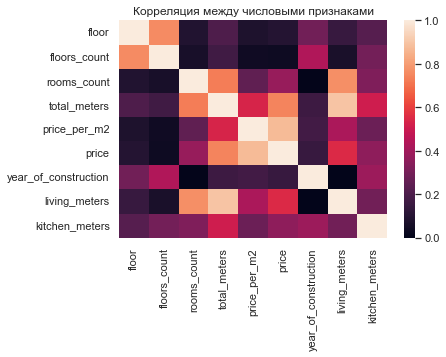

In [14]:
plt.title('Корреляция между числовыми признаками')
sns.heatmap(corr_matrix);

In [15]:
max_corr = (corr_matrix[['living_meters', 'kitchen_meters']].drop(['living_meters', 'kitchen_meters']).abs()).max()
max_corr

living_meters     0.897949
kitchen_meters    0.508889
dtype: float64

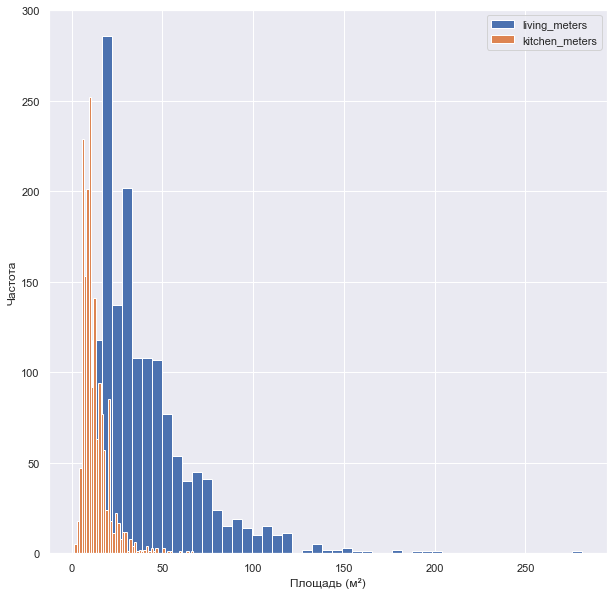

In [16]:
# Построим гистограммы для столбцов "living_meters" и "kitchen_meters"
df['living_meters'].hist(bins = 50, figsize = (10, 10))
df['kitchen_meters'].hist(bins = 50, figsize = (10, 10))
plt.xlabel('Площадь (м²)')
plt.ylabel('Частота')
plt.legend(['living_meters', 'kitchen_meters']);

Группируем датафрейм по столбцу с наибольшей корреляцией - "total_meters". По этим группам вычисляем медианное значение жилой площади и площади кухни. Этими медианными значениями заполняем пропущенные значения в столбцах "living_meters" и "kitchen_meters".

Как видно по графикам выше, распределение жилой площади и площади кухни напоминает распределение Пуассона. При таком смещенном распределении среднее значение может быть сильно смещено в сторону выбросов и не будет характеризовать типичное значение в данных.

Мы решили использовать медианы для замены пропущенных значений признака с распределением Пуассона, поскольку медиана более устойчива к выбросам и не сильно изменит характеристики центральной тенденции распределения. Таким образом, замена пропущенных значений на медиану может быть более надежным и точным способом для признаков с распределением Пуассона.

In [17]:
df['living_meters'] = df['living_meters'].fillna(df.groupby('total_meters')['living_meters'].median())
df['kitchen_meters'] = df['kitchen_meters'].fillna(df.groupby('total_meters')['kitchen_meters'].median())

In [18]:
df.isnull().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction      76
living_meters            722
kitchen_meters           546
district                 255
street                   356
underground                0
residential_complex     1215
dtype: int64

__Вывод:__ Получилось, что замена на медианные значения после группировки с "total_meters" покрыла не все пропуски. Придется обратиться к другому признаку. Глядя на корреляционную матрицу, "total_meters" и "living_meters", положительно коррелируют также и с количеством комнат. Заменим оставшиеся пропуски на медианные значения, группируя датафрейм со столбцом "rooms_count".

In [19]:
for i in range(1, 5):
    df['living_meters'] = df['living_meters'].fillna(round(df.loc[df['rooms_count'] == i , 'living_meters'].median(), 1))
    df['kitchen_meters'] = df['kitchen_meters'].fillna(df.loc[df['rooms_count'] == i , 'kitchen_meters'].median())

In [20]:
df.isnull().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction      76
living_meters              0
kitchen_meters             0
district                 255
street                   356
underground                0
residential_complex     1215
dtype: int64

### Проанализируем сводную статистическую информацию о числовых данных в исходной таблице

In [21]:
df.describe()

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters
count,2293.000000,2293.000000,2293.000000,2293.000000,2.293000e+03,2.293000e+03,2217.000000,2293.000000,2293.000000
mean,9.812473,18.957261,2.406891,76.619520,4.425544e+05,4.212793e+07,2001.700045,34.438487,11.883428
std,10.174896,14.215369,1.066991,45.469129,3.386303e+05,6.872301e+07,26.309680,25.958778,6.435557
min,1.000000,2.000000,1.000000,11.500000,1.144570e+05,3.500000e+06,1826.000000,5.600000,1.500000
25%,3.000000,9.000000,2.000000,42.500000,2.592590e+05,1.220000e+07,1980.000000,18.600000,9.000000
50%,7.000000,16.000000,2.000000,63.500000,3.375000e+05,2.000000e+07,2015.000000,21.500000,9.700000
75%,13.000000,23.000000,3.000000,96.340000,4.771580e+05,4.271510e+07,2022.000000,43.400000,13.400000
max,85.000000,95.000000,5.000000,473.800000,5.378928e+06,1.227180e+09,2026.000000,281.000000,67.000000


__Вывод__: Судя по всему средняя квартира имеет общую площадь 76,62 м², из которых 34,4 м² - жилая площадь и 11,9 м² - площадь кухни. Цена такой квартиры будет 42 127 930 рублей

### EDA. Визуализация

Любопытно посмотреть, какой продавец встречается чаще всего.

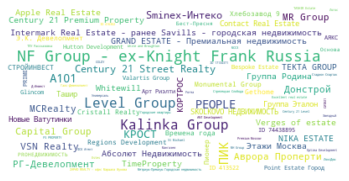

In [22]:
text = df['author'].value_counts().to_dict()
wordcloud = WordCloud(background_color = "white", collocations = True).generate_from_frequencies(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off");

Судя по всему, чаще всего встречается "NF Group - ex-Knight Frank Russia"

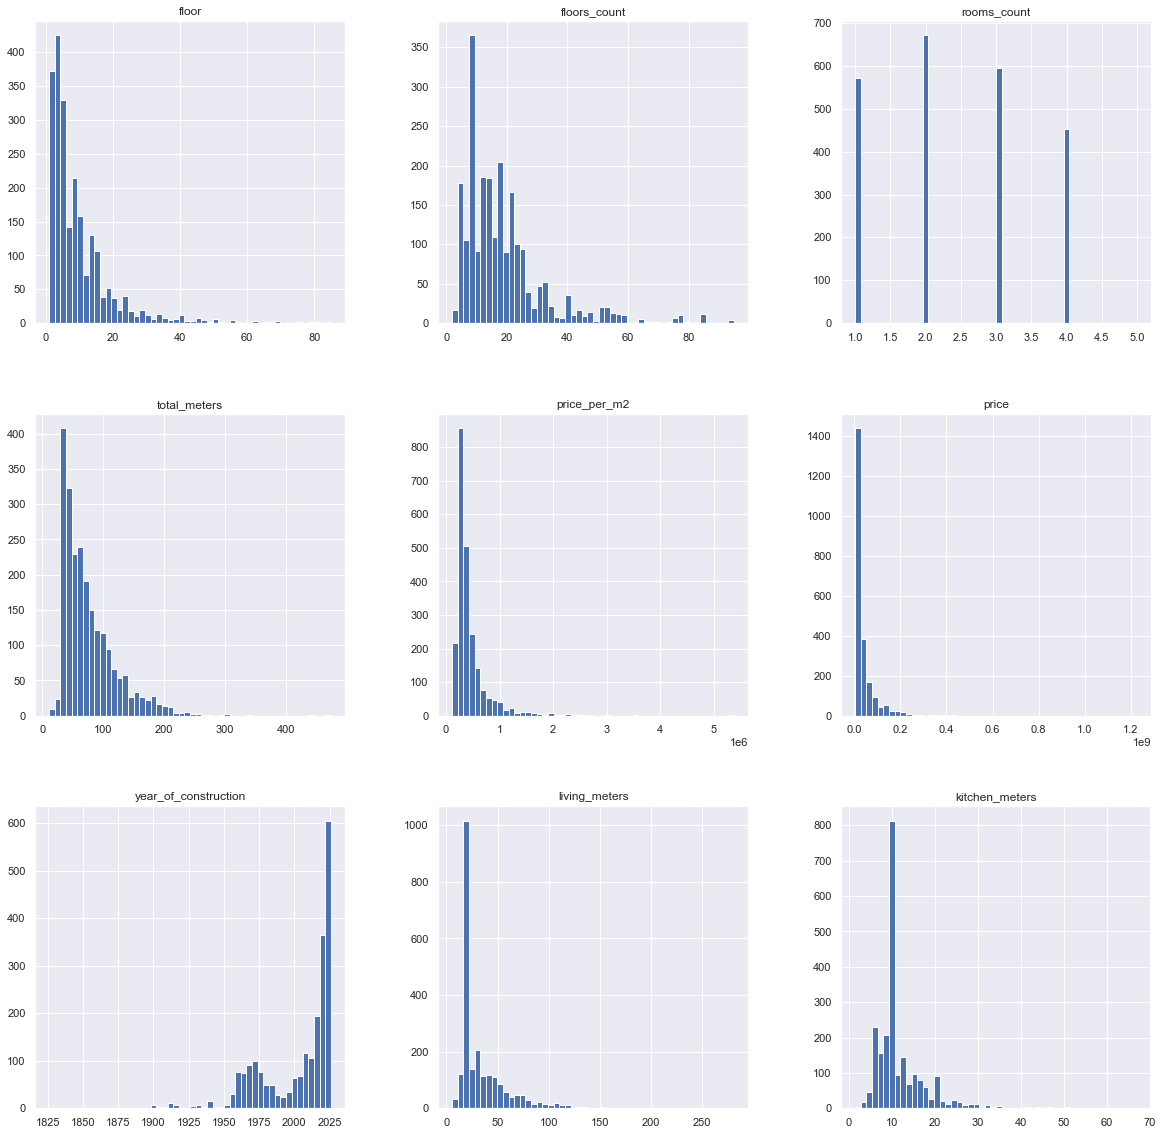

In [23]:
# Еще раз посмотрим на гистограммы для всех числовых переменных
df.hist(bins = 50, figsize = (20, 20));

Из полученных диаграмм можно сделать выводы:
- количество комнат: не похоже на какое-либо распределение
- год постройки здания: похоже на экспоненциальное распределение. Это может означать, что количество "молодой" недвижимости преобладает
- этаж, общее количество этажей, стоимость, стоимость на квадратный метр, общая площадь, жилая площадь и площадь кухни имеют распределение Пуассона. Это может быть связано с тем, что в выборках площади квартир в новостройках или квартир в крупных многоквартирных домах определенные классы площадей квартир, их стоимость и расположение в доме могут быть более популярными, чем другие классы.

#### Изучим информацию по различным параметрам

- Общая площадь:

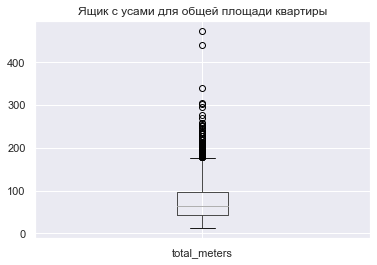

In [24]:
df.boxplot(column = 'total_meters')
plt.title('Ящик с усами для общей площади квартиры');

In [25]:
df['total_meters'].describe().apply('{0:.2f}'.format)

count    2293.00
mean       76.62
std        45.47
min        11.50
25%        42.50
50%        63.50
75%        96.34
max       473.80
Name: total_meters, dtype: object

Найдем значение "верхнего уса":

In [26]:
max_total_m = 96.34 + 1.5 * (96.34 - 42.50)
print(round(max_total_m, 2))

177.1


Количество выбросов:

In [27]:
df.loc[df['total_meters'] > max_total_m].shape[0]

97

Таким образом, средняя площадь квартиры, выставленной на продажу, составляет 76.62 м². В объявлениях содержится много выбросов по параметру общая площадь, это объявления с площадью квартиры более 177.1 м², таких квартир насчитывается 97.

- Жилая площадь:

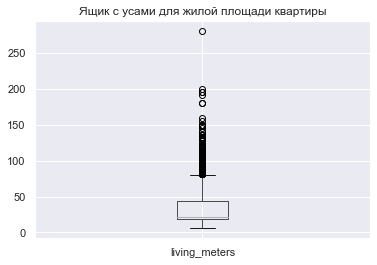

In [28]:
df.boxplot(column = 'living_meters')
plt.title('Ящик с усами для жилой площади квартиры');

In [29]:
df['living_meters'].describe().apply('{0:.2f}'.format)

count    2293.00
mean       34.44
std        25.96
min         5.60
25%        18.60
50%        21.50
75%        43.40
max       281.00
Name: living_meters, dtype: object

Найдем значение "верхнего уса":

In [30]:
max_liv_m = 43.40 + 1.5 * (43.40 - 18.60)
print(round(max_liv_m, 2))

80.6


Количество выбросов:

In [31]:
df.loc[df['living_meters'] > max_liv_m].shape[0]

139

Таким образом, средняя жилая площадь квартиры, выставленной на продажу, составляет 34.44 м². В объявлениях содержится много выбросов по параметру жилая площадь, это объявления с жилой площадью более 80.6 м², таких квартир насчитывается 139.

- Площадь кухни:

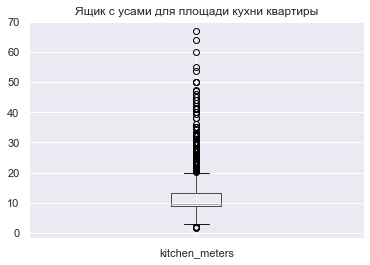

In [32]:
df.boxplot(column = 'kitchen_meters')
plt.title('Ящик с усами для площади кухни квартиры');

In [33]:
df['kitchen_meters'].describe().apply('{0:.2f}'.format)

count    2293.00
mean       11.88
std         6.44
min         1.50
25%         9.00
50%         9.70
75%        13.40
max        67.00
Name: kitchen_meters, dtype: object

Найдем значение "верхнего уса":

In [34]:
max_kit_m = 13.40 + 1.5 * (13.40 - 9.00)
print(round(max_kit_m, 2))

20.0


Количество выбросов:

In [35]:
df.loc[df['kitchen_meters'] > max_kit_m].shape[0]

181

Таким образом, средняя площадь кухни квартиры, выставленной на продажу, составляет 11.88 м². В объявлениях содержится много выбросов по параметру площадь кухни, это объявления с площадью кухни более 20 м², таких квартир насчитывается 181.

- Стоимость:

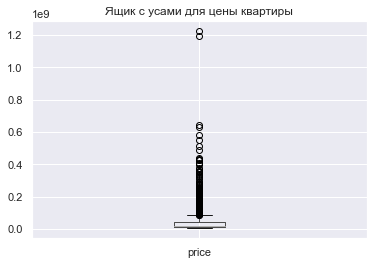

In [36]:
df.boxplot(column = 'price')
plt.title('Ящик с усами для цены квартиры');

In [37]:
df['price'].describe().apply('{0:.2f}'.format)

count          2293.00
mean       42127929.99
std        68723013.88
min         3500000.00
25%        12200000.00
50%        20000000.00
75%        42715100.00
max      1227180000.00
Name: price, dtype: object

Найдем значение "верхнего уса":

In [38]:
max_pr = 42715100.00 + 1.5 * (42715100.00 - 12200000.00)
print(round(max_pr, 2))

88487750.0


Количество выбросов:

In [39]:
df.loc[df['price'] > max_pr].shape[0]

256

Таким образом, средняя цена квартиры, выставленной на продажу, составляет 42 127 929.99 рублей. В объявлениях содержится много выбросов по параметру стоимость, это объявления со стоимостью более 88 487 750 рублей, таких квартир насчитывается 256.

- Стоимость за м²

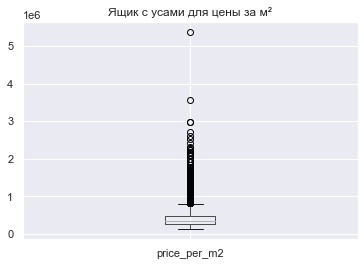

In [40]:
df.boxplot(column = 'price_per_m2')
plt.title('Ящик с усами для цены за м²');

In [41]:
df['price_per_m2'].describe().apply('{0:.2f}'.format)

count       2293.00
mean      442554.37
std       338630.26
min       114457.00
25%       259259.00
50%       337500.00
75%       477158.00
max      5378928.00
Name: price_per_m2, dtype: object

Найдем значение "верхнего уса":

In [42]:
max_pr_m2 = 477158.00 + 1.5 * (477158.00 - 259259.00)
print(round(max_pr_m2, 2))

804006.5


Количество выбросов:

In [43]:
df.loc[df['price_per_m2'] > max_pr_m2].shape[0]

222

Таким образом, средняя цена за м² составляет 442 554.37 рублей. В объявлениях содержится много выбросов по параметру цена за м², это объявления со стоимостью более 804 006.5 рублей, таких квартир насчитывается 222.

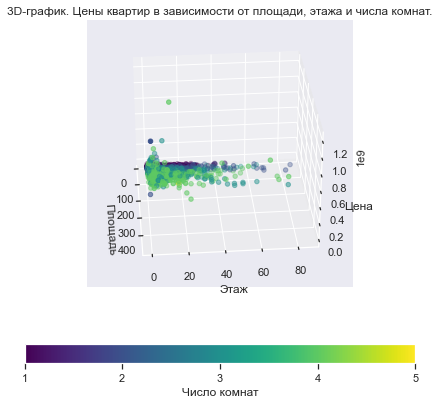

In [44]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection = '3d')

markercolor = df['rooms_count']

x = df['total_meters']
y = df['floor']
z = df['price']

graph = ax.scatter(x, y, z, c = markercolor, cmap = 'viridis')

ax.set_xlabel('Площадь')
ax.set_ylabel('Этаж')
ax.set_zlabel('Цена')
plt.colorbar(graph, label = 'Число комнат', orientation = 'horizontal', location = 'bottom', ticks = [1, 2, 3, 4, 5])
plt.title('3D-график. Цены квартир в зависимости от площади, этажа и числа комнат.');

for angle in range(0, 360, 5):
    ax.view_init(30, angle)
    display(fig)
    plt.pause(.0001)
    clear_output(wait = True)

По расположению и цвету точек можем сделать вывод, что с увеличением площади, этажа и числа комнат, цена тоже увеличивается.

__Примечание:__ этот график заморожен, но если запустить код, то можно посмотреть его обзор на 360 градусов :)

### Корреляционный анализ

Изучим зависимость цены квартиры от числа комнат.

In [45]:
df['price'].corr(df['rooms_count']).round(2)

0.38

Для корреляционного анализа будем использовать не только диаграммы рассеяния, но и гексагональные диаграммы. Графики Hexbin будут полезной альтернативой диаграммам разброса в случа , если данные слишком плотны для построения каждой точки по отдельности.

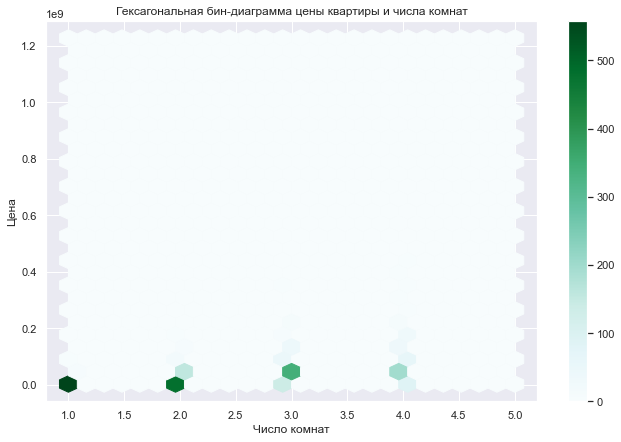

In [46]:
df.plot(x = 'rooms_count', y = 'price', kind = 'hexbin', gridsize = 25, figsize = (11, 7), sharex = False, grid=True)
plt.xlabel('Число комнат')
plt.ylabel('Цена')
plt.title('Гексагональная бин-диаграмма цены квартиры и числа комнат');

Мы видим, что наиболее ярко закрашенная ячейка соответствует однокомнатным квартирам с ценой менее 100млн (по шкале с плотностью справа мы можем сказать, что таких квартир точно больше 500). Также довольно много квартир с 2 и 3 комнатами(плотность приблизительно 400 и 300 соответственно), они также стоят меньше 100 млн.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


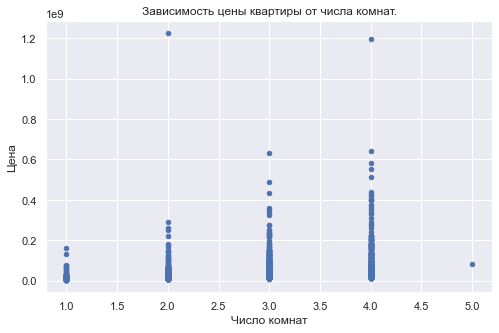

In [48]:
df.plot.scatter(x = 'rooms_count', y = 'price', figsize = (8, 5))
plt.xlabel('Число комнат')
plt.ylabel('Цена')
plt.title('Зависимость цены квартиры от числа комнат.');

Коэффициент корреляции между количеством комнат и стоимостью квартиры 0.38 - умеренная связь, то есть с увеличением числа комнат стоимость квартиры растёт, но это не главный фактор, влияющий на неё.

Изучим зависимость цены квартиры от цены квадратного метра.

In [49]:
df['price'].corr(df['price_per_m2']).round(2)

0.87

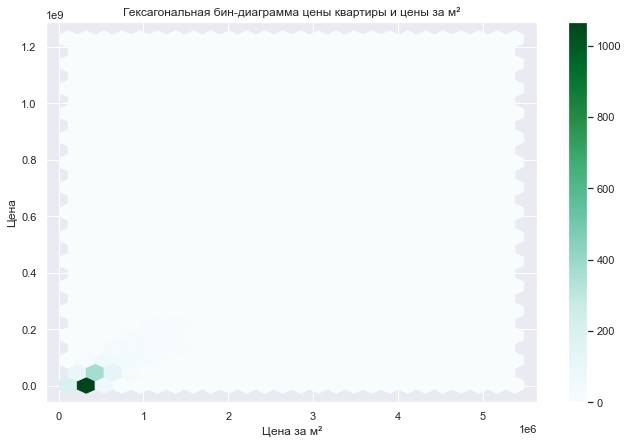

In [50]:
df.plot(x = 'price_per_m2', y = 'price', kind = 'hexbin', gridsize = 25, figsize = (11, 7), sharex = False, grid = True)
plt.xlabel('Цена за м²')
plt.ylabel('Цена')
plt.title('Гексагональная бин-диаграмма цены квартиры и цены за м²');

Мы видим, что наиболее ярко закрашенная ячейка находится близко к нижнему левому углу графика, который соответствует более низким значениям цены за квадратный метр и цены квартиры. Это может указывать на наличие определённого сегмента рынка недвижимости, где цены на квартиры и цена за квадратный метр являются наиболее доступными или низкими.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


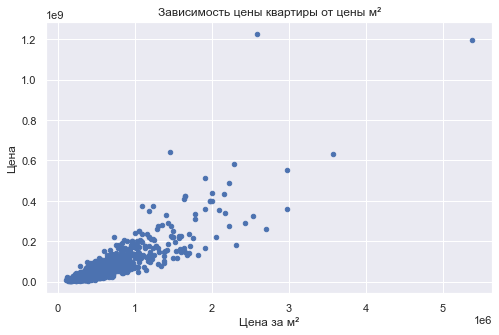

In [51]:
df.plot.scatter(x = 'price_per_m2', y = 'price', figsize = (8, 5))
plt.xlabel('Цена за м²')
plt.ylabel('Цена')
plt.title('Зависимость цены квартиры от цены м²');

Коэффициент корреляции между цены м² и стоимостью квартиры 0.87 - очень сильная положительная связь, то есть с увеличением числа комнат стоимость квартиры растёт.

Изучим зависимость цены квартиры от удалённости станции метро от центра. Для этого создадим новый столбец 'is_CAO' с закодированными данными столбца 'underground'.

In [52]:
# Создадим список станций метро, которые относятся к центральному административному округу
CAO_underground = ['Рижская', 'Проспект Мира', 'Сухаревская',
                   'Тургеневская', 'Китай-город', 'Третьяковская',
                   'Октябрьская', 'Белорусская', 'Маяковская',
                   'Тверская', 'Театральная', 'Новокузнецкая',
                   'Павелецкая', 'Площадь Ильича', 'Марксистская',
                   'Третьяковская', 'Бауманская', 'Курская',
                   'Площадь Революции', 'Арбатская', 'Смоленская',
                   'Красносельская', 'Комсомольская', 'Красные Ворота',
                   'Чистые Пруды', 'Лубянка','Охотный Ряд', 'Библиотека им. Ленина',
                   'Парк Культуры', 'Фрунзенская', 'Спортивная',
                   'Воробьевы Горы', 'Кропоткинская', 'Смоленская',
                   'Арбатская', 'Александровский Сад', 'Проспект Мира',
                   'Комсомольская', 'Курская', 'Таганская', 'Павелецкая',
                   'Добрынинская', 'Октябрьская', 'Парк Культуры',
                   'Краснопресненская', 'Белорусская', 'Новослободская',
                   'Улица 1905 года', 'Баррикадная', 'Пушкинская',
                   'Кузнецкий Мост', 'Китай-город', 'Пролетарская',
                   'Таганская', 'Менделеевская', 'Цветной Бульвар',
                   'Чеховская', 'Боровицкая', 'Полянка', 'Серпуховская']

In [53]:
df['is_CAO'] = df['underground'].apply(lambda x: 1 if x in CAO_underground else 0)

In [54]:
df['price'].corr(df['is_CAO']).round(2)

0.45

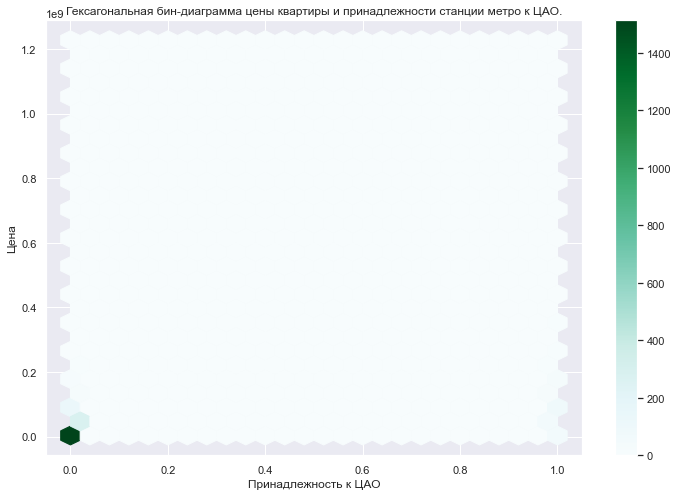

In [55]:
df.plot(x = 'is_CAO', y = 'price', kind = 'hexbin', gridsize = 25, figsize = (12, 8), sharex = False, grid = True)
plt.xlabel('Принадлежность к ЦАО')
plt.ylabel('Цена')
plt.title('Гексагональная бин-диаграмма цены квартиры и принадлежности станции метро к ЦАО.');

Мы видим, что наиболее ярко закрашенная ячейка соответствует низкому значению цен и категории квартир, которые находятся на станциях метро, не принадлежащих ЦАО. Это может указывать на то, что более удалённые от центра квартиры имеют меньшую стоимость.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


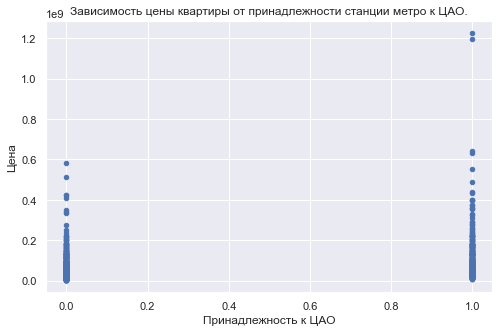

In [56]:
df.plot.scatter(x = 'is_CAO', y = 'price', figsize = (8, 5))
plt.xlabel('Принадлежность к ЦАО')
plt.ylabel('Цена')
plt.title('Зависимость цены квартиры от принадлежности станции метро к ЦАО.');

Коэффициент корреляции между количеством комнат и стоимостью квартиры 0.45 - умеренная связь, то есть чем ближе станция метро, тем выше стоимость квартиры, но это не главный фактор, влияющий на неё.

Изучим зависимость цены квартиры от года постройки дома.

In [57]:
df['price'].corr(df['year_of_construction']).round(2)

0.14

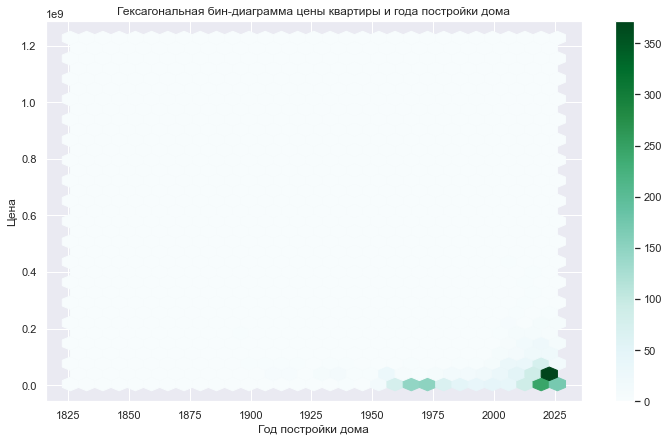

In [58]:
df.plot(x = 'year_of_construction', y = 'price', kind = 'hexbin', gridsize = 30, figsize = (12, 7), sharex = False, grid=True)
plt.xlabel('Год постройки дома')
plt.ylabel('Цена')
plt.title('Гексагональная бин-диаграмма цены квартиры и года постройки дома');

Самые сильно закрашенные ячейки расположены в правом нижнем углу, при этом ячейка с наибольшей плотностью располагается выше, чем все ячейки для более старых домов(это указывает на большую стоимость квартир). Таким образом,более новые дома имеют более высокую стоимость квартир.

Такое наблюдение может иметь смысл, так как новые дома часто имеют современные удобства, лучшую изоляцию, современный дизайн и другие преимущества, которые могут повысить их стоимость. Более старые дома могут требовать ремонта или обновления, что может сказываться на цене квартир в них.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


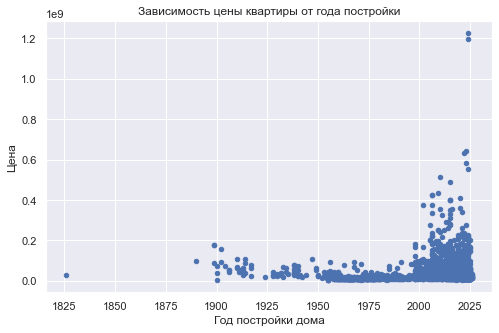

In [60]:
df.plot.scatter(x = 'year_of_construction', y = 'price', figsize = (8, 5))
plt.xlabel('Год постройки дома')
plt.ylabel('Цена')
plt.title('Зависимость цены квартиры от года постройки');

Коэффициент корреляции между годом постройки дома и стоимостью квартиры 0.14 - слабая положительная связь, то есть это не главный фактор, влияющий на стоимость квартиры.

Изучим зависимость цены квартиры от этажа.

In [61]:
df['price'].corr(df['floor']).round(2)

0.1

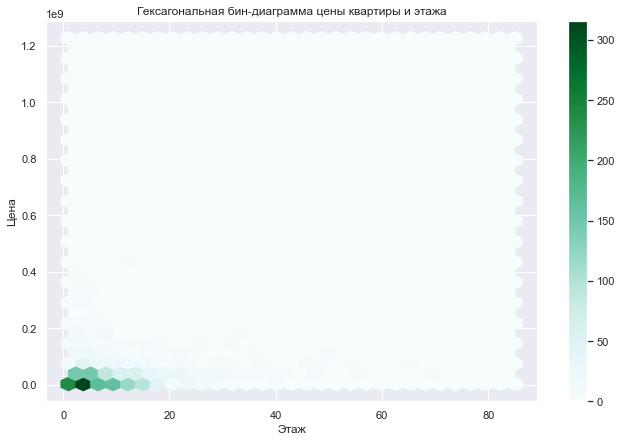

In [62]:
df.plot(x = 'floor', y = 'price', kind = 'hexbin', gridsize = 30, figsize = (11, 7), sharex = False, grid=True)
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.title('Гексагональная бин-диаграмма цены квартиры и этажа');

Самые сильно закрашенные ячейки расположены в нижнем левом углу, это может указывать на следующую закономерность: цены на квартиры могут быть ниже в случае, когда квартира расположена на нижних этажах.

Такое наблюдение может иметь смысл, так как квартиры на нижних этажах могут иметь некоторые недостатки или ограничения, которые влияют на их стоимость. Например, квартиры на первом этаже могут иметь ограниченный вид, более высокий уровень шума или ограниченную приватность. В то время как квартиры на верхних этажах могут иметь лучший вид и более высокий уровень приватности, что может повысить их стоимость.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


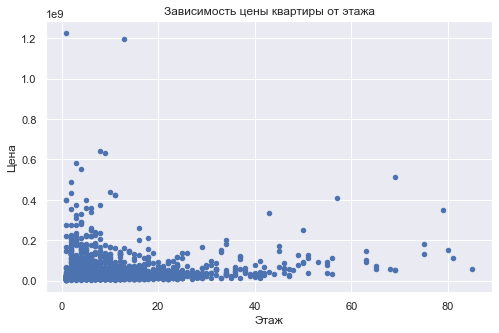

In [63]:
df.plot.scatter(x = 'floor', y = 'price', figsize = (8, 5))
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.title('Зависимость цены квартиры от этажа');

Коэффициент корреляции между количеством этажей и стоимостью квартиры 0.1 - очень слабая связь, то есть это не главный фактор, влияющий на стоимость квартиры.

Изучим зависимость цены квартиры от общей этажности дома.

In [64]:
df['price'].corr(df['floors_count']).round(2)

0.04

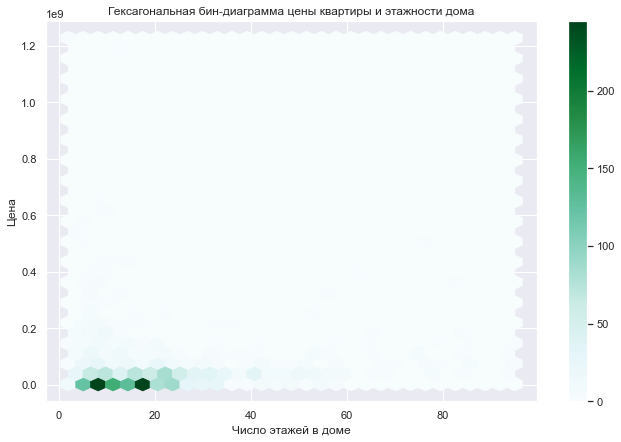

In [65]:
df.plot(x = 'floors_count', y = 'price', kind = 'hexbin', gridsize = 30, figsize = (11, 7), sharex = False, grid=True)
plt.xlabel('Число этажей в доме')
plt.ylabel('Цена')
plt.title('Гексагональная бин-диаграмма цены квартиры и этажности дома');

Самые сильно закрашенные ячейки расположены в нижнем левом углу (в промежутке до 20 по оси x), это может указывать на следующую закономерность: цены на квартиры могут быть ниже в случае, когда дом имеет небольшую этажность (до 20 этажей).

Такое наблюдение может иметь смысл, так как в небольших домах обычно меньше квартир, что может создавать меньшую конкуренцию среди покупателей и влиять на цены. Кроме того, более крупные многоэтажные дома могут иметь дополнительные удобства и услуги, которые могут повысить стоимость квартир.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


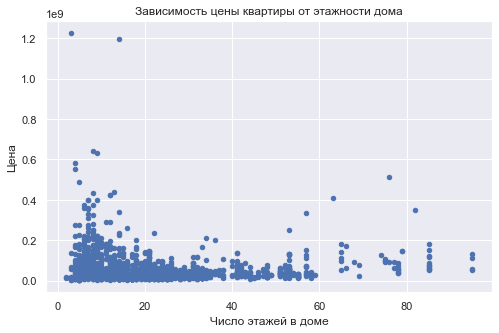

In [66]:
df.plot.scatter(x = 'floors_count', y = 'price', figsize = (8, 5))
plt.xlabel('Число этажей в доме')
plt.ylabel('Цена')
plt.title('Зависимость цены квартиры от этажности дома');

Коэффициент корреляции между количеством этажей в доме и стоимостью квартиры 0.04 - очень слабая связь, то есть это не главный фактор, влияющий на стоимость квартиры.

## Создание новых переменных

Помимо ранее созданной переменной "is_CAO" создадим ещё несколько переменных, которые пригодятся нам для анализа.

1) соотношение жилой площади и площади кухни

2) категория дома (сталинка, хрущёвка, брежневка, монолитный дом, новостройка)

In [233]:
df['area_ratio'] = (df['living_meters'] / df ['kitchen_meters']).round(2)

In [234]:
def class_of_house(row):
    if 1820 <= row['year_of_construction'] < 1840:
        typ = 'Филановский'
    elif 1840 <= row['year_of_construction'] < 1855:
        typ = 'Никитинский'
    elif 1855 <= row['year_of_construction'] < 1870:
        typ = 'Ковалёвский'
    elif 1870 <= row['year_of_construction'] < 1940:
        typ = 'Печатники'
    elif 1940 <= row['year_of_construction'] < 1950:
        typ = 'Сталинка'
    elif 1950 <= row['year_of_construction'] < 1960:
        typ = 'Хрущёвка'
    elif 1960 <= row['year_of_construction'] < 1980:
        typ = 'Брежневка'
    elif 1980 <= row['year_of_construction'] < 2018:
        typ = 'Монолитный'
    else :
        typ = 'Новостройка'
    return typ

df['house_category'] = df.apply (class_of_house, axis=1)

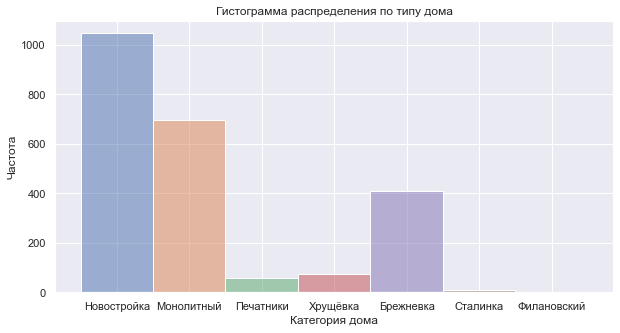

In [235]:
sns.set(rc = {'figure.figsize' : (10, 5)})
sns.histplot(x = 'house_category', hue = 'house_category', legend = False, data = df, bins = 50)
plt.xlabel('Категория дома')
plt.ylabel('Частота')
plt.title('Гистограмма распределения по типу дома');

В наших данных чаще всего встречаются новостройки и монолитные дома.

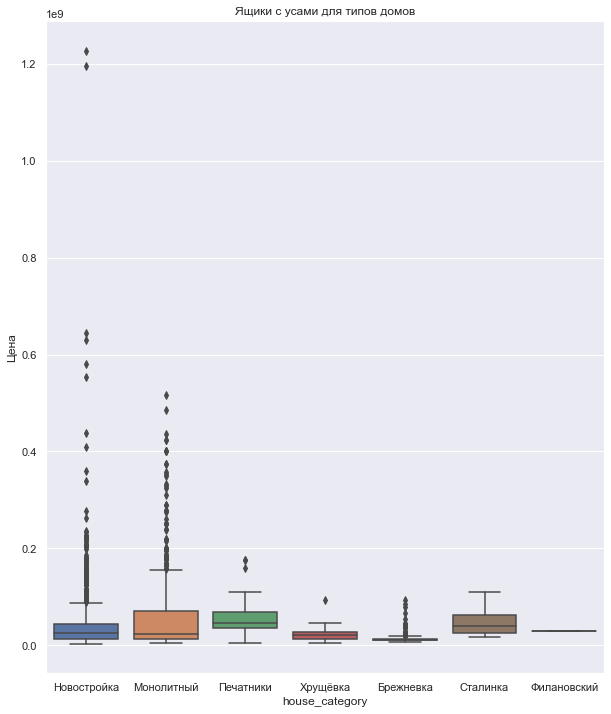

In [236]:
sns.set(rc = {'figure.figsize' : (10, 12)})
sns.boxplot(y = df.price, x = df['house_category'])
plt.ylabel('Цена')
plt.title('Ящики с усами для типов домов');

Из данных графика мы можем сделать вывод о том, что печатники и сталинки ценятся больше, чем другие типы домов (об этом говорит уровень медианных значений), такие отличия могут быть связаны с различиями в качестве жилья и инфраструктуре вокруг домов разных категорий.

Самая большая вариативность на квартиры наблюдается в монолитных домах, что можно увидеть по размаху между верхним и нижним квартилями, а также по выбросам за пределами усов.

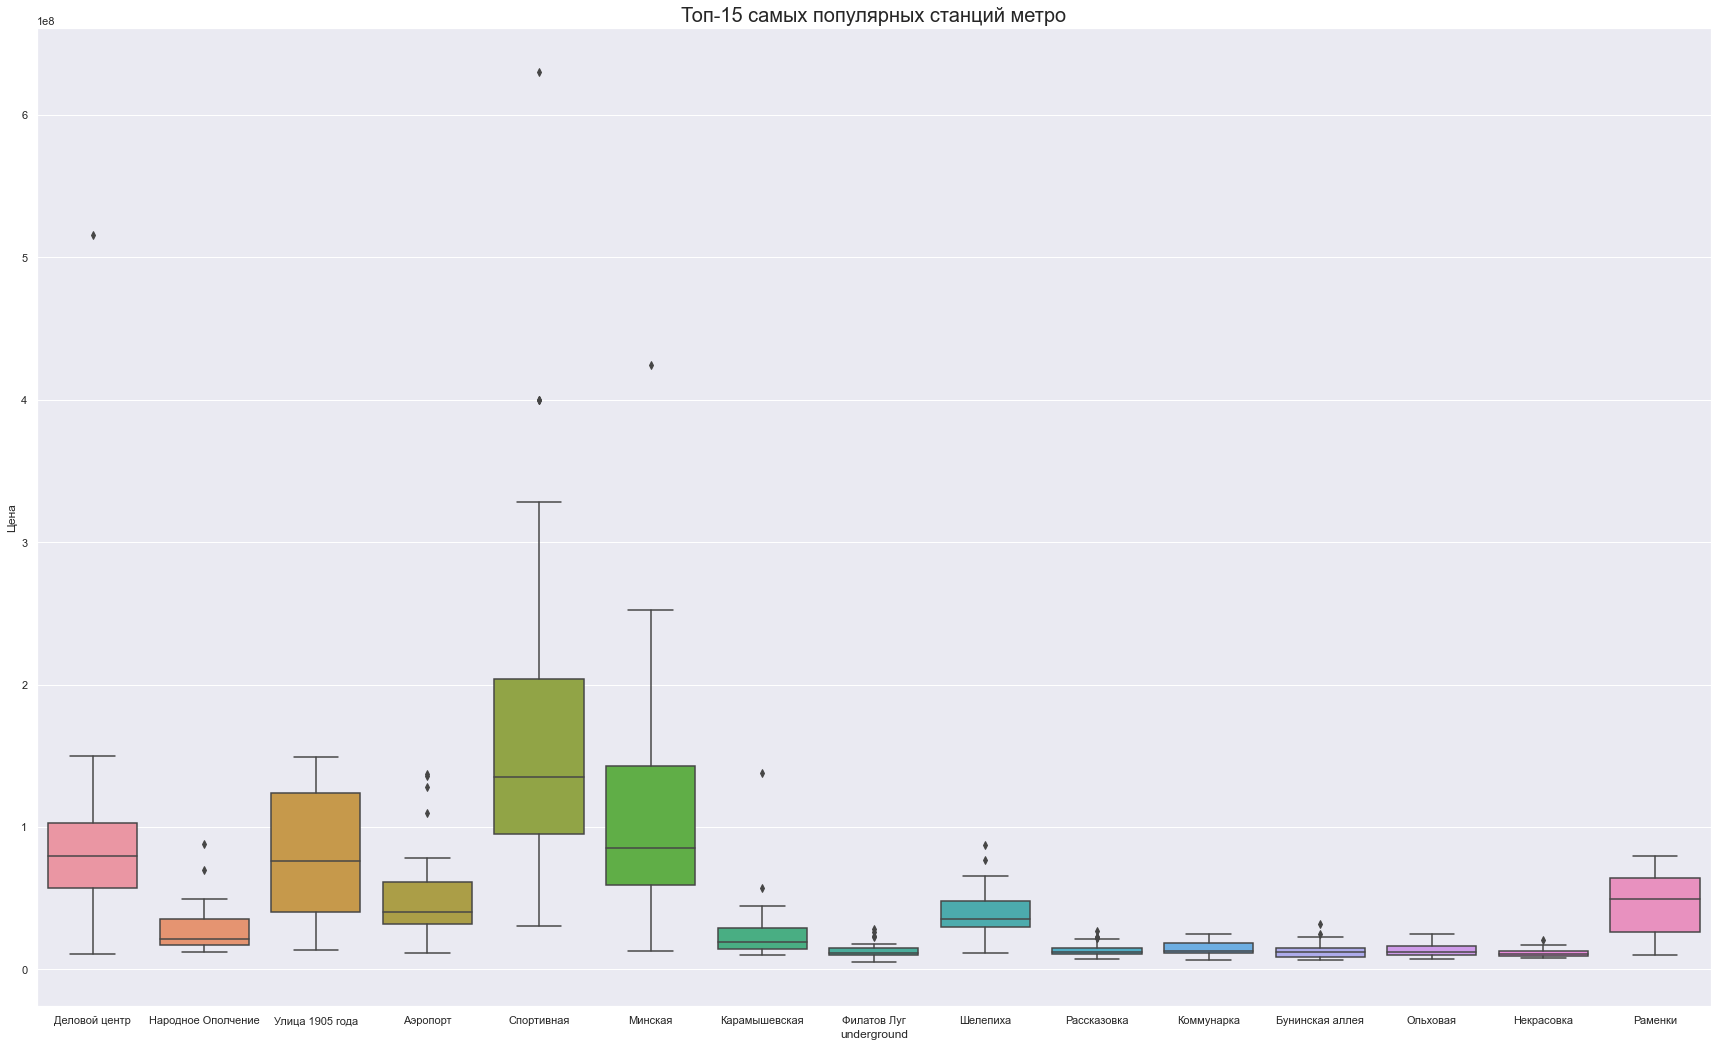

In [237]:
sns.set(rc = {'figure.figsize' : (30, 18)})
sns.boxplot(y = df[df.underground.isin(list(df.underground.value_counts().head(15).index))].price,
            x = df[df.underground.isin(list(df.underground.value_counts().head(15).index))].underground)
plt.ylabel('Цена')
plt.title('Топ-15 самых популярных станций метро', size = 20);

По графикам можно увидеть, что самые низкие цены на станции Некрасовка, а самые высокие на Спортивной, Минской, Деловом центре.

Вариативность цен на квартиры на станциях метро Спортивная и Минская достаточно большая, как это видно по размаху между верхним и нижним квартилями, а также по наличию выбросов за пределами усов.

Довольно схожее распределение цен на квартиры на станциях Деловой центр, Улица 1905 года; Карамышевская, Народное ополчение; Рассказовка, Бунинская аллея, Ольховая, это указывает нам на схожие рыночное предложение и спрос в этих районах.

## Гипотезы

In [238]:
# будем использовать эту функцию для построения красивых графиков
def asy_mean_test(mean_hat, std_hat, n, mu_0=0, 
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    
    z_obs = abs((mean_hat - mu_0)/std_hat)
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.t(df = n).cdf(np.abs(z_obs)))
        z_crit = sts.t(df = n).ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = sts.t(df = n).cdf(-z_obs)
        z_crit = sts.t(df= n).ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - sts.t(df = n).cdf(z_obs)
        z_crit = sts.t(df = n).ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (8, 4))
    x = np.linspace(-margin, margin)
    pdf = sts.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = sts.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return (f'p-value: {p_value}')

### Гипотеза №1: Квартира от застройщика стоит столько же, сколько и квартира, продаваемая агентствами недвижимости.

Будем сравнивать средние цены от застройщиков и агентств недвижимости при уровне значимости α = 5%. В виде гипотез это формулируется так:
                                               
\begin{equation*}
    \begin{aligned}
    & H_0: μ_d = μ_a \\
    & H_1: μ_d < μ_a, \\ 
    \end{aligned}
\end{equation*}

                                               где μ𝑑 = мат.ожидание цен от застройщиков
                                               μ𝑎 = мат. ожидание цен от агентств


In [239]:
# отсортируем списки квартир от застройщика и агентств
developer_prices = df[df['author_type'] == 'developer']['price']
agent_prices = df[df['author_type'] == 'real_estate_agent']['price']

p-value = 3.5420046512726606e-10
Отвергаем нулевую гипотезу


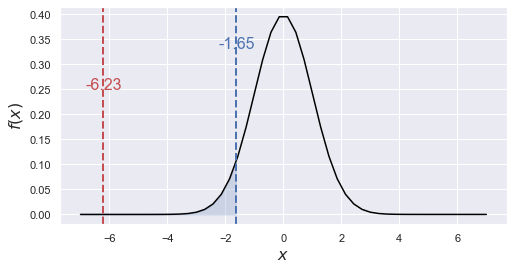

In [240]:
t_statistic, p_value = sts.ttest_ind(developer_prices, agent_prices, alternative='less')
alpha = 0.05

print(f"p-value = {p_value}")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

mean_hat = developer_prices.mean() - agent_prices.mean()
n = len(developer_prices) + len(agent_prices) - 2
var_0 = (np.sum((developer_prices - developer_prices.mean())**2) + np.sum((agent_prices - agent_prices.mean())**2)) / n
diff_std = np.sqrt(var_0 * (1/len(developer_prices) + 1/len(agent_prices)))
asy_mean_test(mean_hat, std_hat = diff_std, n = n,  mu_0=0, alpha=0.05, alternative='less', margin=7);

**Вывод:** получается, что цены на квартиры от агентств недвижимости значительно (из-за очень маленького p-value) превышают цены квартир от застройщиков 

### Гипотеза №2: Квартиры на высоких этажах стоят дешевле, чем квартиры на нижних этажах.

Анализируя гексагональную бин-диаграмму цены квартиры и этажа, мы заметили, что цены на квартиры могут быть ниже в случае, когда квартира расположена на нижних этажах. Проверим это с помощью t-теста. Сравним средние цены на нижних этажах и на верхних при уровне значимости α = 5%. В виде гипотез это формулируется так:
                                               
\begin{equation*}
    \begin{aligned}
    & H_0: μ_l = μ_h \\
    & H_1: μ_l < μ_h, \\ 
    \end{aligned}
\end{equation*}

                                               где μl = мат.ожидание цен на нижних этажах
                                               μh = мат. ожидание цен на верхних этажах


Отсортируем этажи по верхним и нижним, считаем, что 1, 2, 3, 4 - нижние этажи, с 4 по 9 - средние, а выше 9 - верхние, чтобы получилось примерно равное количество наблюдений.

In [241]:
floor_low = df[df['floor'] <= 4]['price']
floor_high = df[df['floor'] > 9]['price']

In [242]:
print((floor_low).size)
print((floor_high).size)

797
811


Посмотрим на количество элементов в каждой выборке, они +- равны, что прекрасно

p-value = 0.4161
Не отвергаем нулевую гипотезу


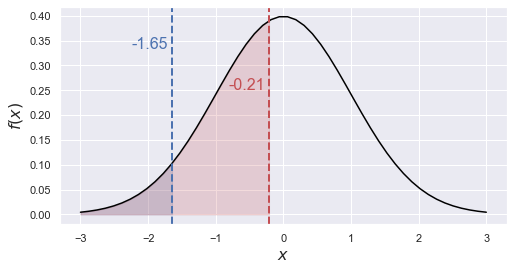

In [243]:
t_statistic, p_value = sts.ttest_ind(floor_high, floor_low, alternative='less')
alpha = 0.05

print(f"p-value = {round(p_value, 4)}")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

mean_hat = floor_low.mean() - floor_high.mean()
n = len(floor_low) + len(floor_high) - 2
var_0 = (np.sum((floor_low - floor_low.mean())**2) + np.sum((floor_high - floor_high.mean())**2)) / n
diff_std = np.sqrt(var_0 * (1/len(floor_low) + 1/len(floor_high)))
asy_mean_test(mean_hat, std_hat = diff_std, n = n, alpha=0.05, alternative='less', margin=3);

__Вывод:__ Вот так да, ДИ и t-статистика говорят нам, что средние цены на квартиры на нижних этажах не меньше, чем средние цены на квартиры на верхних этажах. Возможно это связано с особенностями выборки, например, большое количество выбросов.

### Гипотеза №3: Количество комнат и близость метро к центру одинаково влияют на стоимость жилья.

Проведя корреляционный анализ, мы пришли к выводу, что увеличение комнат влияет на цену положительно, так же как и расстояния от ближайшей станции метро до центра (чем ближе - тем дороже, у нас это 'is_CAO'). Проверим с помощью t-теста равны ли средние цены при большом количестве комнат(3+) и средние цены рядом со станциями метро, относящихся к ЦАО. Сравним это при уровне значимости α = 5%. В виде гипотез это формулируется так:
                                               

\begin{equation*}
    \begin{aligned}
    & H_0: μ_r = μ_u \\
    & H_1: μ_r < μ_u, \\ 
    \end{aligned}
    \end{equation*}

                                               где μr = мат.ожидание цен при большом количестве комнат
                                               μu = мат. ожидание цен у метро в ЦАО


In [244]:
room_cost = df[df['rooms_count'] >= 3]['price']
under_cost = df[df['is_CAO'] == 1]['price']

p-value = 4.275869073770559e-17
Отвергаем нулевую гипотезу


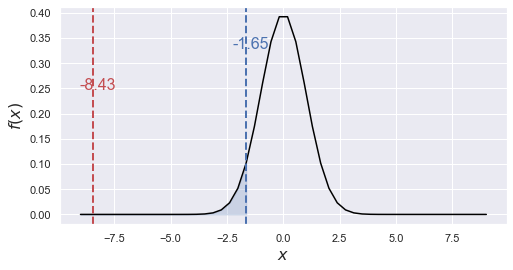

In [245]:
t_statistic, p_value = sts.ttest_ind(room_cost, under_cost, alternative='less')
alpha = 0.05

print(f"p-value = {p_value}")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

mean_hat = under_cost.mean() - room_cost.mean()
n = len(under_cost) + len(room_cost) - 2
var_0 = (np.sum((under_cost - under_cost.mean())**2) + np.sum((room_cost - room_cost.mean())**2)) / n
diff_std = np.sqrt(var_0 * (1/len(under_cost) + 1/len(room_cost)))
asy_mean_test(mean_hat, std_hat = diff_std, n = n, alpha=0.05, alternative='less', margin=9);

__Вывод:__ видим, что гипотеза о том, что количество комнат и близость метро к центру одинаково влияют на стоимость жилья, отвергается. Более того, мы так же понимаем (из-за положения t-stat), что именно количество комнат сильнее влияет на цену квартиры, а не близость метро к центру Москвы 

### Гипотеза № 4: В ЦАО и в других районах квартиры одинакового размера.

Не просто так, мы выше рассчитали 'area_ratio' соотношение жилой площади и площади кухни. Предположим, что это среднее этих соотношений для всех районов одинаковое. Проверим это при уровне значимости α = 5%. В виде гипотез это формулируется так:
                                               

\begin{equation*}
    \begin{aligned}
    & H_0: μ_c = μ_o \\
    & H_1: μ_c > μ_o, \\ 
    \end{aligned}
    \end{equation*}

                                               где μc = мат.ожидание соотношения жилой площади и кухни в ЦАО
                                               μa = мат.ожидание соотношения жилой площади и кухни в остальных районах

In [246]:
area_ratio_CAO = df[df['is_CAO'] == 1]['area_ratio']
area_ratio_other = df[df['is_CAO'] == 0]['area_ratio']

p-value: 0.0004
Отвергаем нулевую гипотезу


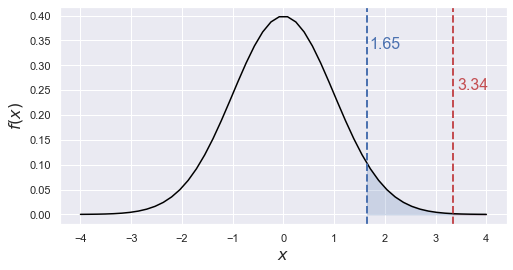

In [247]:
t_statistic, p_value = sts.ttest_ind(area_ratio_CAO ,area_ratio_other , alternative='greater')
alpha = 0.05

print(f"p-value: {round(p_value, 4)}")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

mean_hat = area_ratio_CAO.mean() - area_ratio_other.mean()
n = len(area_ratio_CAO) + len(area_ratio_other) - 2
var_0 = (np.sum((area_ratio_CAO - area_ratio_CAO.mean())**2) + np.sum((area_ratio_other - area_ratio_other.mean())**2)) / n
diff_std = np.sqrt(var_0 * (1/len(area_ratio_CAO) + 1/len(area_ratio_other)))
asy_mean_test(mean_hat, std_hat = diff_std, n = n, alpha=0.05, alternative='larger', margin=4);

__Вывод:__ Вот так оно и получается, что в ЦАО соотношение жилой площадь квартиры и её кухни значительно больше, чем это же соотношение в других административных районах

### Гипотеза № 5: Цена за квадратный метр отличается между квартирами различных застройщиков.

Так как у нас есть много разных застройщиков, и мы хотите проверить гипотезу о различии цен за квадратный метр между группами застройщиков, нам стоит использовать однофакторный дисперсионный анализ (ANOVA) вместо проведения множественных парных t-тестов.
Здесь нулевой гипотезой будет - средние значения всех групп равны между собой, то есть средние цены за квадратный метр у разных застройщиков одинаковые. Уровень значимости = 5%

In [248]:
# Сначала отсортируем исходный датафрейм так, чтобы получить предложения только от застройщиков
developer_data = df[df['author_type'] == 'developer']

In [249]:
# Создаём словарь, в котором ключ - застройщик, а значения - цены за квадратный метр
prices_by_author = {}
for author, group in developer_data.groupby('author'):
    prices_by_author[author] = group['price_per_m2']

# Применение однофакторного дисперсионного анализа ANOVA
f_statistic, p_value = sts.f_oneway(*prices_by_author.values())

print("p-value =", p_value)

p-value = 2.760661217189589e-19


__Вывод:__ нулевая гипотеза отвергается, а это значит, что статистически значимые различия между группами существуют и цены за квадратный метр у застройщиков отличаются.

### Гипотеза №6: Нет различия в ценах на квартиры в зависимости от типа дома.

Выше мы создали новый признак 'house_category', который определяет тип дома в зависимости от даты застройки. Любопытно посмотреть, различаются ли цены на квартиры в зависимости от типа дома. Опять же нам стоит использовать однофакторный дисперсионный анализ (ANOVA) вместо проведения множественных парных t-тестов. Здесь нулевой гипотезой будет - средние цены на квартиры у всех типов домов равны. Уровень значимости = 5%

In [250]:
# Создаём словарь, в котором ключ - тип дома, а значения - цены
house_category = {}
for category, group in df.groupby('house_category'):
    house_category[category] = group['price']

# Применение однофакторного дисперсионного анализа ANOVA
f_statistic, p_value = sts.f_oneway(*house_category.values())

print("p-value =", p_value)

p-value = 1.1240278390486028e-21


__Вывод:__ очевидно, что нулевая гипотеза отвергается, а это значит, что цена на квартиру сильно зависит от типа дома.

# Машинное обучение

В данном разделе мы попробуем построить модель, прдесказывающую стоимость квартиры на основе базовых признаков, которые можно найти в объявлениях на Циане. Многие компании и физические лица, занимающиеся продажей, оценкой, страхованием недвижимости, стремяться максимально точно определить стоимость квартиры, но человеческие возможности эмпирического анализа достаточно ограничены, поэтому в дело идет модели машинного обучения, которые могут помочь справиться с этой задачей. В данном случае мы будем использовать линейные регрессии с разными гиперпараметрами, а также почти безотказный инструмент - Catboost. Оценку качества модели будем проводить по таким параметрам, как RMSE, MAE, MAPE, R^2. 

In [280]:
df.head()

,author,author_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex,is_CAO,area_ratio,house_category
1,ФСК Агент,real_estate_agent,4,30,2.0,70.60,390934,27600000,2023.0,34.8,16.5,Хорошево-Мневники,NaN,Хорошёво,Сидней Сити ЖК,0,2.11,Новостройка
2,Тауэрс,developer,46,66,2.0,84.40,746000,62962400,2020.0,18.6,9.7,Пресненский,1-й Красногвардейский проезд,Выставочная,NEVA TOWERS,0,1.92,Новостройка
3,Тауэрс,developer,65,78,3.0,81.50,865000,70497500,2019.0,18.6,9.7,Пресненский,1-й Красногвардейский проезд,Выставочная,NEVA TOWERS,0,1.92,Новостройка
4,Wainbridge,developer,14,20,2.0,63.70,431711,27500000,2023.0,18.6,9.7,Левобережный,Ленинградское шоссе,Беломорская,Aquatoria,0,1.92,Новостройка
7,GRAVION,developer,3,9,2.0,75.48,982728,74176316,2023.0,18.6,9.7,Якиманка,Ленинский проспект,Октябрьская,CULT (Апартаменты премиум-класса),1,1.92,Новостройка


In [251]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn. linear_model import RidgeCV
from sklearn. model_selection import RepeatedKFold
from sklearn. linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor


Убираем аномальные значения цены, используя 1.5 интерквантильный размах

In [252]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

df = df[(df['price'] <= upper) & (df['price'] >= lower)]

In [253]:
df.isnull().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction      62
living_meters              0
kitchen_meters             0
district                 255
street                   348
underground                0
residential_complex     1179
is_CAO                     0
area_ratio                 0
house_category             0
dtype: int64

В столбце residential_complex слишком большое количество выбросов, больше половины от общего количества, поэтому мы удаляем этот столбец, а также удаляем столбец price_per_m2, так как это производная от нашей целевой переменной.

In [254]:
df_clear = df.drop(columns = ['residential_complex', 'price_per_m2'])

Обозначаем целевую переменную и делим выборку

In [257]:
#обозначаем целевую переменную и делим выборку
y = df_clear["price"]
X = df_clear.drop(columns = ['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

# отбираем только числовые признаки
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.median()
numeric_features = numeric_data.columns

#заполняем пропуски
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

Нормализация данных

In [258]:
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

Зададим функцию для удобного вывода

In [259]:
def show():
    print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
    print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
    print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))
    print("Test R2 = %.4f" % r2_score(y_test, y_pred))
    print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
    print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
    print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))

Используя кросс-валидацию и перебор по лямбде, ищем параметр, при котором достигается наименьшая MSE для Ridge регрессии

In [260]:
cv = RepeatedKFold(n_splits= 10 , n_repeats= 3 , random_state= 6 )
model = RidgeCV(alphas = np.arange(0.01, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X_train[numeric_features], y_train)

y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

show()

Test RMSE = 9788295.2888
Train RMSE = 9342167.6866
Test MAPE = 0.2746
Train MAPE = 0.2741
Test R2 = 0.7245
Train R2 = 0.7285
Test MAE = 6400075.6190
Train MAE = 6258321.7462


Используя кросс-валидацию и перебор по лямбде, ищем параметр, при котором достигается наименьшая MSE для LASSO регрессии

In [261]:
cv = RepeatedKFold(n_splits= 10 , n_repeats= 3 , random_state= 7 )
model = LassoCV(alphas = np.arange(0.01, 1, 0.01), cv=cv)
model.fit(X_train[numeric_features], y_train, y_train)

y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

show()

Test RMSE = 10583446.1788
Train RMSE = 10003994.3713
Test MAPE = 0.3822
Train MAPE = 0.3728
Test R2 = 0.6780
Train R2 = 0.6886
Test MAE = 7729598.9481
Train MAE = 7371864.8844


Используем линейную регрессию с дефолтными параметрами

In [262]:
model = LinearRegression()
model.fit(X_train[numeric_features], y_train)

y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

show()

Test RMSE = 9788268.2885
Train RMSE = 9342167.6843
Test MAPE = 0.2746
Train MAPE = 0.2741
Test R2 = 0.7245
Train R2 = 0.7285
Test MAE = 6400052.3981
Train MAE = 6258313.2451


Линейные регрессии с регуляризацией и без показывают примерно одни и те же результаты. На данном этапе результаты средние, попробуем их улучшить с помощью бустанутого кота :)

### Catboost

Подбираем лучшие параметры перебором по сетке

In [263]:
# Загрузка данных
train_data = X_train[numeric_features]
eval_data = X_test[numeric_features]
train_labels = y_train

# Определение модели
model = CatBoostRegressor()

# Определение сетки параметров для перебора
param_grid = {
    'iterations': [100,400, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
    'logging_level':["Silent"]
}

# Инициализация объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Запуск поиска по сетке
grid_search.fit(X_train[numeric_features], y_train)

# Вывод наилучших параметров и значения метрик
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.01, 'logging_level': 'Silent'}


Используем лучшие подобранные параметры для модели

In [264]:
model = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.01,
                          depth = 6 ,
                          loss_function='RMSE',
                          logging_level = "Silent")
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

show()

Test RMSE = 9161176.2966
Train RMSE = 6583799.2152
Test MAPE = 0.2329
Train MAPE = 0.1985
Test R2 = 0.7587
Train R2 = 0.8651
Test MAE = 5688393.9477
Train MAE = 4434636.3655


Применение Catboost значительно улучшило каждую из метрик, но не останавливаемся и пробуем добиться еще лучшего результата

#### Примением OneHotEncoding и посмотрим на результаты

В данном случае мы ограничены в количестве столбцов к которым применяем ohe, чтобы не сделать слишком большое количество признаков и сохранить адекватное соотношение количества признаков к количеству записей, поэтому посмотрим количество уникальных категорий по категориальным признакам.

In [265]:
df_clear.district.value_counts().shape[0]

121

In [266]:
df_clear.street.value_counts().shape[0]

711

In [267]:
df_clear.underground.value_counts().shape[0]

258

District, underground и street описывают местоположение квартиры или дома, мы можем выбрать один из них и не потерять в качестве. В district и  street также много пропусков, поэтому оптимальным решением будет оставить underground.

In [268]:
df_clear.author_type.value_counts().shape[0]

7

In [269]:
df_clear.house_category.value_counts().shape[0]

7

author_type и house_category имеют немного категорий, поэтому их тоже закодируем.

In [270]:
df_clear.author.value_counts().shape[0]

1424

author удаляем, так как слишком большое количество категорий, да и особо смысла он не несет

In [271]:
encoded_data = pd.get_dummies(df_clear[['underground', 'author_type', 'house_category']])
df_new = pd.concat([df_clear, encoded_data], axis =1)

In [272]:
#обозначаем целевую переменную и делим выборку
y = df_new["price"]
X = df_new.drop(columns = ['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

# делим выборку
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

#заполняем пропуски 
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [273]:
model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

show()

Test RMSE = 7842297.4125
Train RMSE = 6197265.6877
Test MAPE = 0.2478
Train MAPE = 0.1870
Test R2 = 0.8232
Train R2 = 0.8805
Test MAE = 5245786.6676
Train MAE = 4113490.8036


In [274]:
model = Lasso()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

show()

Test RMSE = 8195161.5206
Train RMSE = 5979025.1109
Test MAPE = 0.2673
Train MAPE = 0.1819
Test R2 = 0.8069
Train R2 = 0.8888
Test MAE = 5375732.2814
Train MAE = 3920373.2291


Метрики приятно улучшились благодаря onehotencoding и дополнительной очистке данных. Попробуем применить новые данные к Catboost.

In [275]:
# Загрузка данных
train_data = X_train[numeric_features]
eval_data = X_test[numeric_features]
train_labels = y_train

# Определение модели
model = CatBoostRegressor()

# Определение сетки параметров для перебора
param_grid = {
    'iterations': [300, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
    'logging_level':["Silent"]
}

# Инициализация объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Запуск поиска по сетке
grid_search.fit(X_train[numeric_features], y_train)

# Вывод наилучших параметров и значения метрик
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1, 'logging_level': 'Silent'}


In [276]:
model = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.1,
                          depth = 6 ,
                          loss_function='RMSE',
                          logging_level = "Silent",
                          eval_metric = "RMSE")
model.fit(train_data, train_labels)
y_pred = model.predict(eval_data)
y_train_pred = model.predict(train_data)

show()

Test RMSE = 6950050.4832
Train RMSE = 2337454.0860
Test MAPE = 0.1922
Train MAPE = 0.0898
Test R2 = 0.8611
Train R2 = 0.9830
Test MAE = 4386131.3432
Train MAE = 1790777.7549


Для Catboost OHE также позволил улучшить метрики. В целом модель уже имеет достаточно хорошую предсказательную силу. Доля дисперсии зависимой переменной, объяснённой с помощью регрессионной модели (R^2) = 0.86, в среднем ошибка соствляет 19% от фактического значения, но абсолютное значение ошибки все же не маленькое = 4_400_000р.

Документация Catboost говорит о том, что библиотека способна сама обрабатывать категориальные признаки, поэтому задаем новый параметр cat_features, куда передаем названия категориальных признаков.

In [277]:
df.isnull().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction      62
living_meters              0
kitchen_meters             0
district                 255
street                   348
underground                0
residential_complex     1179
is_CAO                     0
area_ratio                 0
house_category             0
dtype: int64

Catboost не может работать с nan и просит сделать их строками. Также заполним числовые пропуски медианными значениями.

In [278]:
#обозначаем целевую переменную и делим выборку
y = df["price"]
X = df.drop(columns = ['price', "price_per_m2"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

# отбираем только числовые признаки
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.median()
numeric_features = numeric_data.columns

#заполняем пропуски
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

#делаем пропуски строкой
X_train = X_train.fillna("NaN")
X_test = X_test.fillna("NaN")

In [279]:
model = CatBoostRegressor(loss_function='RMSE',
                          logging_level = "Silent",
                          eval_metric = "RMSE", 
                          cat_features =  ['author', "author_type", 'district',
                                           'street', 'residential_complex', 'underground', 'house_category'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

show()

Test RMSE = 6406179.0232
Train RMSE = 4082639.4713
Test MAPE = 0.1571
Train MAPE = 0.1106
Test R2 = 0.8820
Train R2 = 0.9481
Test MAE = 3943046.0321
Train MAE = 2627953.9336


Да, действительно, Catboost отлично справляется сам с категориальными данными. Метрики снова улучшились и можно сказать, что качество модели хорошее, она однозначно имеет смысл.

Дополнительно можно попробовать применить Scaler и снова запустить бустинг

In [160]:
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

In [161]:
model = CatBoostRegressor(loss_function='RMSE',
                          logging_level = "Silent",
                          eval_metric = "RMSE", 
                          cat_features =  ['author', "author_type", 'district',
                                           'street', 'residential_complex', 'underground', 'house_category'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

show()

Test RMSE = 6668006.1783
Train RMSE = 4082639.4713
Test MAPE = 0.1560
Train MAPE = 0.1106
Test R2 = 0.8722
Train R2 = 0.9481
Test MAE = 4014015.6633
Train MAE = 2627953.9336


In [166]:
#обозначаем целевую переменную и делим выборку
y = df["price"]
X = df.drop(columns = ['price', "price_per_m2", 'author', 'residential_complex'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

# отбираем только числовые признаки
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.median()
numeric_features = numeric_data.columns

#заполняем пропуски,
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

#делаем пропуски строкой
X_train = X_train.fillna("NaN")
X_test = X_test.fillna("NaN")

Метрики почти не изменились, поэтому особого смысла в этом не было.

## Вывод

Если не знаешь, что делать с данными, просто импортни catboost и запусти на дефолтных параметрах, он сам разберется......
А если серьезно, то модель имеет место на жизнь и неплохую предсказательную способность. То есть, мы можем прогнозировать цену на основе таких данных, как географическое положение (станция метро, район, улица), количество комнат, этажность здания и этаж квартиры, год постройки здания, жилая площадь и площадь кухни и некоторых других. Если увеличить количество собранных данных, можно добиться еще более точного результата и сделать достаточно точную модель.

При этом нужно четко разграничивать время сбора данных для анализа, потому что данные месячной давности могут уже быть не очень актуальными (например, война может начаться, доллар 120 стать, ключ в космос улететь, льготную ипотеку прикрыть, платежноспособное население уехать в казахские степи, в общем других факторов, влияющих на стоимость квартиры, очень много и их тоже нужно учитывать при построение модели.